In [22]:
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context # ignore certificate error in download
df = pd.read_csv("https://math.ucla.edu/~dmenezes/meta.csv", index_col = 0)

In [20]:
df.index = pd.to_datetime(df.index)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-18,210.000000,213.380005,208.300003,210.770004,210.770004,16580800
2022-04-19,210.520004,218.429993,209.000000,217.309998,217.309998,20089900
2022-04-20,213.610001,214.160004,198.919998,200.419998,200.419998,43036500
2022-04-21,201.600006,202.970001,185.580002,188.070007,188.070007,49954100
2022-04-22,190.369995,192.720001,183.270004,184.110001,184.110001,36426800
...,...,...,...,...,...,...
2023-04-10,214.710007,215.660004,210.660004,214.750000,214.750000,16106100
2023-04-11,215.479996,216.020004,213.410004,213.850006,213.850006,16710100
2023-04-12,214.839996,216.839996,212.580002,214.000000,214.000000,18972200


Text(0.5, 1.0, 'Facebook Closing Stock Price 4/18/2022 to 4/18/2023')

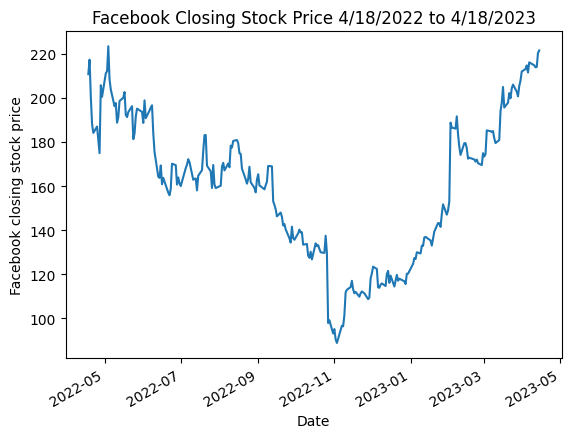

In [24]:
df["Close"].plot()
plt.xlabel("Date")
plt.ylabel("Facebook closing stock price")
plt.title("Facebook Closing Stock Price 4/18/2022 to 4/18/2023")

In [25]:
from statsmodels.tsa.stattools import adfuller


In [26]:
adfuller(df["Close"])

(-1.3251264680933372,
 0.6175999763394585,
 0,
 249,
 {'1%': -3.4568881317725864,
  '5%': -2.8732185133016057,
  '10%': -2.5729936189738876},
 1473.181031063517)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

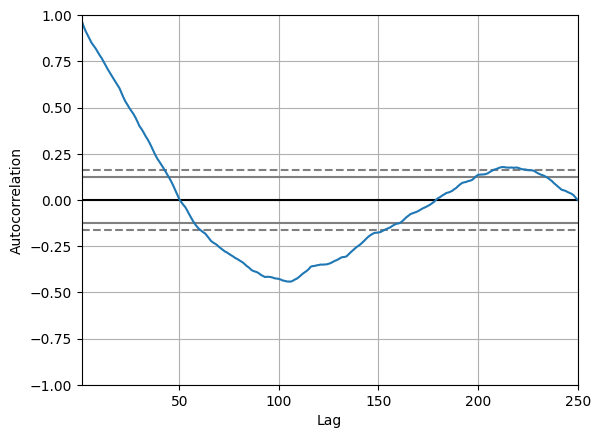

In [28]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

autocorrelation_plot(df["Close"])

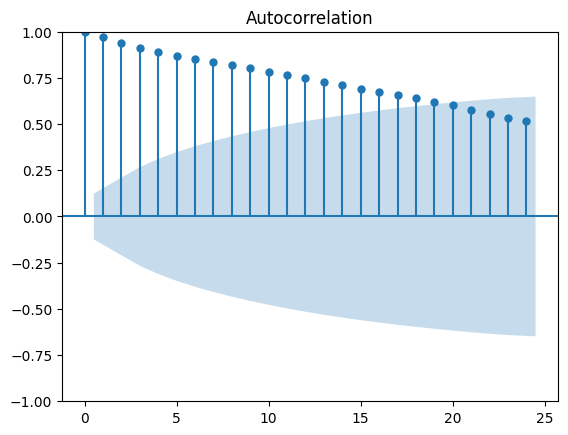

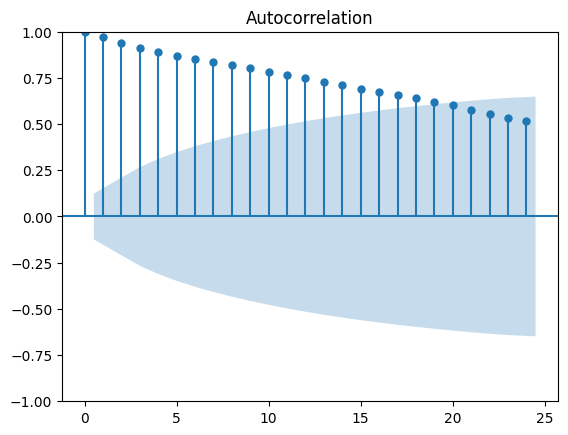

In [29]:
plot_acf(df["Close"])

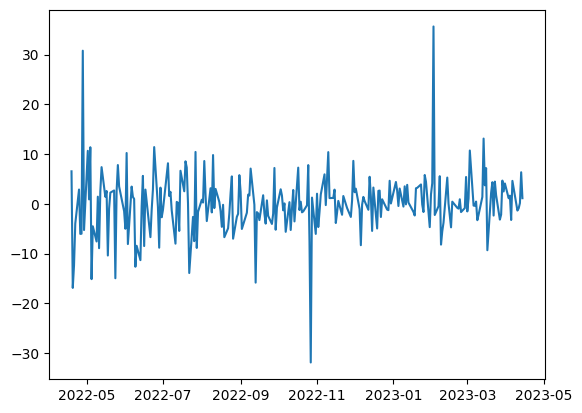

In [33]:

walk_diff = pd.Series(df["Close"]).diff().dropna()

plt.plot(walk_diff);

In [45]:
adfuller(walk_diff)

(-16.036165530240233,
 5.982934393953174e-29,
 0,
 248,
 {'1%': -3.4569962781990573,
  '5%': -2.8732659015936024,
  '10%': -2.573018897632674},
 1466.1125710200424)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

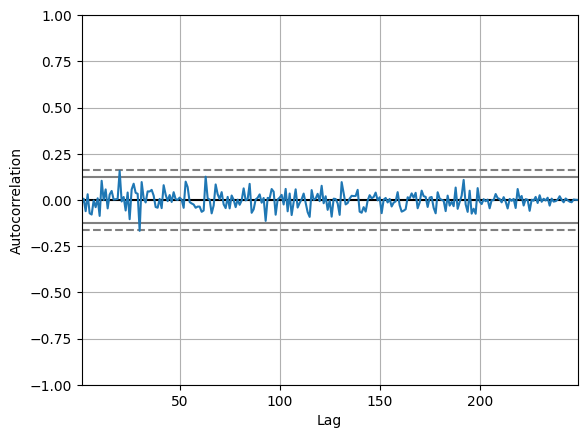

In [34]:
autocorrelation_plot(walk_diff)

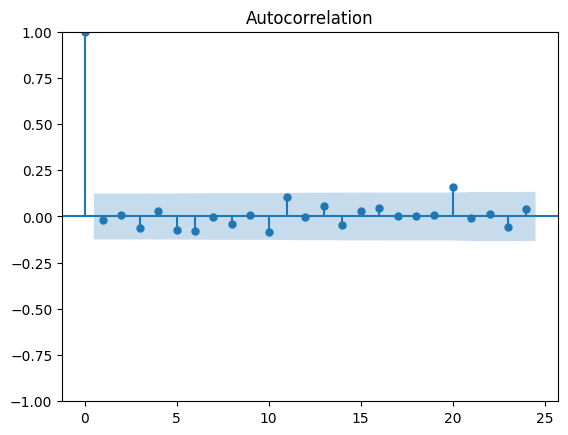

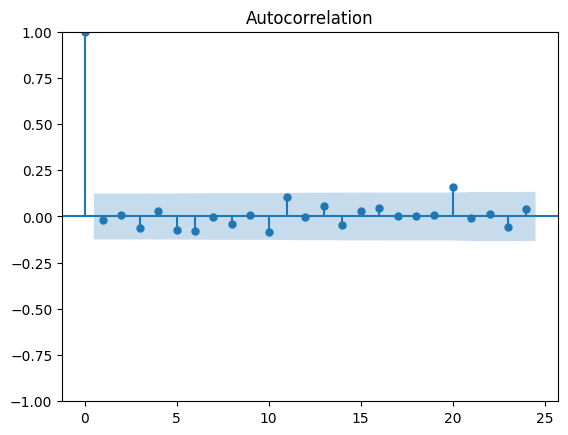

In [35]:
plot_acf(walk_diff)

If we perform an Augmented Dickey-Fuller test on the Facebook stock prices, we get that the stock price has a unit root, because we fail to reject the null hypothesis.  This is what we would expect if the series is a random walk.

If we take first differences then we do get a series that is stationary since the ADF test rejects the null hypothesis that the series has a unit root, which is also what we would expect if the series were a random walk. 

Furthermore, if we look at the differences in the Facebook stock prices, we get that the differences appear to be independent, which we can see by looking at the autocorrelation plot.  



In [38]:
test_set = df["Close"][-5:]

In [39]:
test_set

Date
2023-04-10    214.750000
2023-04-11    213.850006
2023-04-12    214.000000
2023-04-13    220.350006
2023-04-14    221.490005
Name: Close, dtype: float64

In [40]:
train_set = df["Close"][:-5]

In [48]:
import numpy as np
avg = np.mean(train_set)

In [49]:
avg

158.90171423265306

In [52]:
np.mean((test_set - avg)**2)

3373.470717620785

If we simply take the average over the train set as the prediction, then we get a prediction of 158.90 as the stock price.

We get a mean squared error of 3373.47

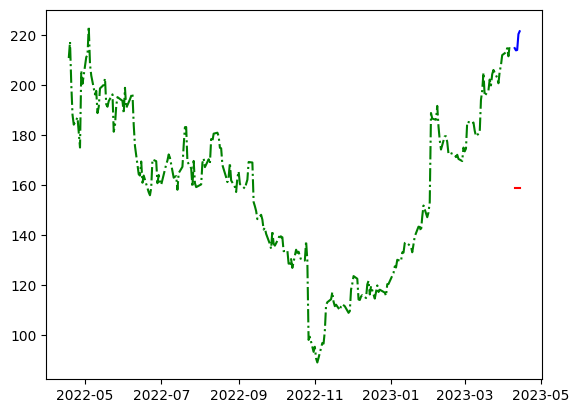

In [61]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(train_set, 'g-.', label='Train')
ax.plot(test_set, 'b-', label='Test')
ax.plot(test_set.index, np.array([avg]*5), 'r-', label="pred")

Another naive forecasting method is to use the last known value.

In [63]:
ult = train_set[-1]

In [64]:
np.mean((test_set - ult)**2)

11.681926124014586

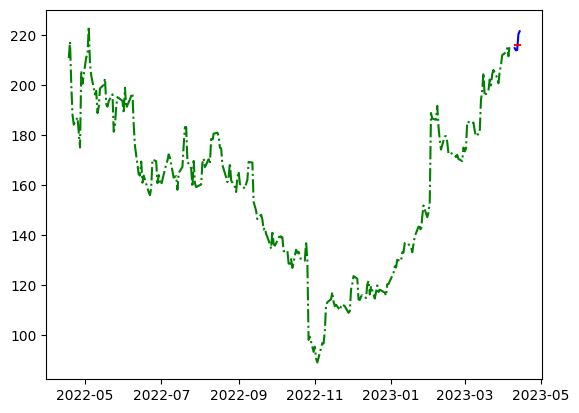

In [65]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(train_set, 'g-.', label='Train')
ax.plot(test_set, 'b-', label='Test')
ax.plot(test_set.index, np.array([ult]*5), 'r-', label="pred")

If we use the last known trading day's closing price as our forecast, we get a better forecast which we can see from the plot.  

In [68]:
md = np.mean(walk_diff)

In [72]:
pred = [ult + md] + list(test_set[:-1] + md) 
# We predict the next timestep by assuming that the next day's closing price is given by a random walk, with mean md

In [73]:
pred

[216.1430582128514,
 214.7930522128514,
 213.8930582128514,
 214.0430522128514,
 220.3930582128514]

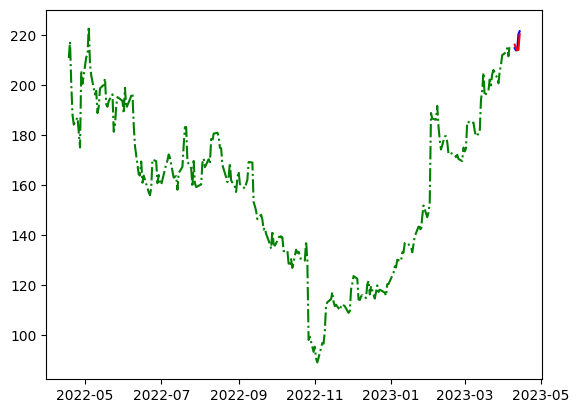

In [74]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(train_set, 'g-.', label='Train')
ax.plot(test_set, 'b-', label='Test')
ax.plot(test_set.index, np.array(pred), 'r-', label="pred")

In [75]:
np.mean((test_set - pred)**2)

8.764468443373698

If we do a walk-forward where we predict the next timestep as the mean of the difference plus the previous day's timestep (thus assuming that it follows a random walk where the random jump has a given mean), we get an even lower mean squared error of 8.76.